# Milestone 1


The very first step is finding out the patterns, which human uses when creating a password. 
As a dataset we decided to start with a rockyou-45.txt - a list with 6190 stolen passwords. 
All leaked databases, with even more passwords can be found here: https://github.com/danielmiessler/SecLists/tree/master/Passwords/Leaked-Databases

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')

file_name = 'rockyou45.txt'
path = F"/content/gdrive/My Drive/Colab Notebooks/{file_name}" 

passwords_file = open(path, encoding = "ISO-8859-1")

In [0]:
passwords = passwords_file.read()

In [5]:
token = nltk.word_tokenize(passwords)
print(token)

['123456', '12345', '123456789', 'password', 'iloveyou', 'princess', '1234567', '12345678', 'abc123', 'nicole', 'daniel', 'babygirl', 'monkey', 'lovely', 'jessica', '654321', 'michael', 'ashley', 'qwerty', '111111', 'iloveu', '000000', 'michelle', 'tigger', 'sunshine', 'chocolate', 'password1', 'soccer', 'anthony', 'friends', 'butterfly', 'purple', 'angel', 'jordan', 'liverpool', 'justin', 'loveme', 'fuckyou', '123123', 'football', 'secret', 'andrea', 'carlos', 'jennifer', 'joshua', 'bubbles', '1234567890', 'superman', 'hannah', 'amanda', 'loveyou', 'pretty', 'basketball', 'andrew', 'angels', 'tweety', 'flower', 'playboy', 'hello', 'elizabeth', 'hottie', 'tinkerbell', 'charlie', 'samantha', 'barbie', 'chelsea', 'lovers', 'teamo', 'jasmine', 'brandon', '666666', 'shadow', 'melissa', 'eminem', 'matthew', 'robert', 'danielle', 'forever', 'family', 'jonathan', '987654321', 'computer', 'whatever', 'dragon', 'vanessa', 'cookie', 'naruto', 'summer', 'sweety', 'spongebob', 'joseph', 'junior', 

At the first glance we can see the following difficulties, which we are going to face while analyzing this data:

1) Multiple words written without spaces

2) words and numbers

3) words with replaced letters (e.g. passw0rd)

4) you = u, two = 2, see = c and so on

While counting the number of symbols, there were not many capital letters, and therefore all passwords were changed to lower case. 

In [0]:
passwords = passwords.lower()

In [7]:
from collections import Counter
c = Counter(passwords)
print(c)
print(c["!"])

Counter({'\n': 6162, 'a': 4324, 'e': 4276, 'i': 2935, 'o': 2832, 'n': 2719, 'r': 2672, 'l': 2475, 's': 2321, 't': 1820, 'c': 1449, 'm': 1446, 'd': 1227, '1': 1209, 'y': 1143, 'h': 1074, 'b': 1066, 'u': 1027, 'p': 904, 'g': 871, 'k': 712, '2': 509, 'v': 490, 'f': 423, 'j': 398, 'w': 371, '3': 353, '5': 257, '4': 256, '9': 214, '0': 207, '6': 205, '8': 173, 'z': 172, '7': 156, 'x': 152, 'q': 84, '.': 12, '!': 11, '*': 6, ' ': 4, '-': 2, '#': 2, ';': 1, '?': 1, ',': 1, '/': 1, 'ñ': 1, '@': 1, '$': 1, '%': 1, '^': 1})
11


Next step is turning the string values into tensors for further usage. 
The following article, "Text Predictor - Generating Rap Lyrics" brought us to idea of turning letters into their frequencies of usage https://towardsdatascience.com/text-predictor-generating-rap-lyrics-with-recurrent-neural-networks-lstms-c3a1acbbda79
All words were enlarged to the length of the longest password in the dataset (17).

In [8]:
max_token = len(max(token, key=len))

import torch

passwords_tensor = torch.Tensor([[c[x] for x in list(t) + [0 for i in range(max_token - len(list(t)))]] for t in token])
print(passwords_tensor)

tensor([[1209.,  509.,  353.,  ...,    0.,    0.,    0.],
        [1209.,  509.,  353.,  ...,    0.,    0.,    0.],
        [1209.,  509.,  353.,  ...,    0.,    0.,    0.],
        ...,
        [  84., 1027., 4324.,  ...,    0.,    0.,    0.],
        [ 904., 2475., 4324.,  ...,    0.,    0.,    0.],
        [1446., 2832., 2719.,  ...,    0.,    0.,    0.]])


In [9]:
passwords_tensor.shape

torch.Size([6190, 17])

To normalize data, we used preprocessing with sklearn.

In [10]:
from sklearn import preprocessing

X_normalized = preprocessing.normalize(passwords_tensor.numpy(), norm='l2')
passwords_tensor_n = torch.from_numpy(X_normalized)
passwords_tensor_n

tensor([[0.8509, 0.3582, 0.2484,  ..., 0.0000, 0.0000, 0.0000],
        [0.8599, 0.3620, 0.2511,  ..., 0.0000, 0.0000, 0.0000],
        [0.8305, 0.3497, 0.2425,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0099, 0.1216, 0.5119,  ..., 0.0000, 0.0000, 0.0000],
        [0.1347, 0.3687, 0.6442,  ..., 0.0000, 0.0000, 0.0000],
        [0.2069, 0.4052, 0.3891,  ..., 0.0000, 0.0000, 0.0000]])

For unsupervised classification the k-means method was implemented. Using the elbow method we decided to come up with 15 clusters.

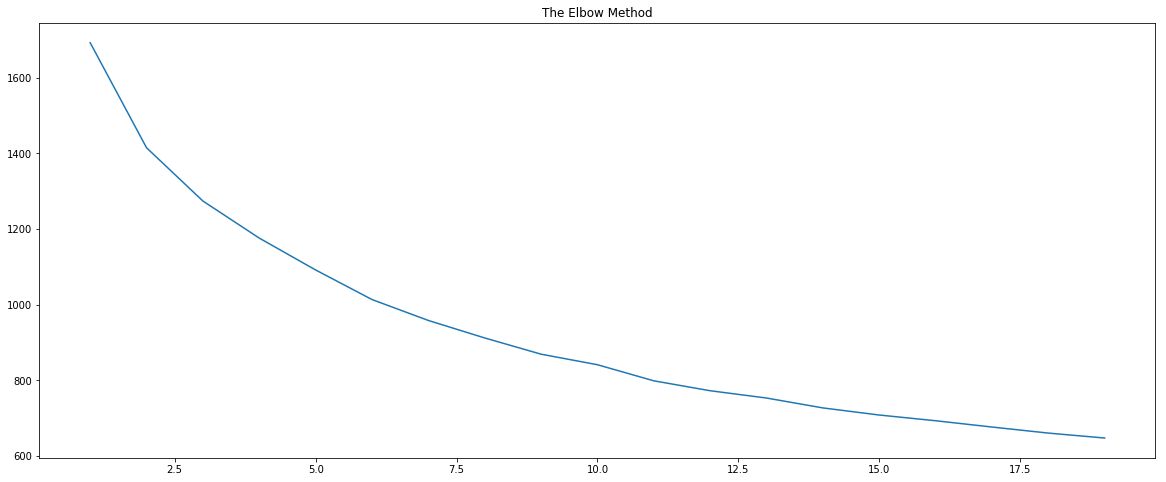

In [11]:
import matplotlib.pyplot as plt
num_it = 20
plt.figure(figsize=(num_it, 8))
from sklearn.cluster import KMeans
clust = []
for i in range(1, num_it):
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(passwords_tensor_n)
    clust.append(kmeans.inertia_)
plt.plot(range(1, num_it), clust)
plt.title('The Elbow Method')
plt.show()

In [12]:
kmeans = KMeans(n_clusters = 15, init = 'k-means++')
y_kmeans = torch.from_numpy(kmeans.fit_predict(passwords_tensor_n))
for i, t in enumerate(token):
  print(t, y_kmeans[i])

123456 tensor(11, dtype=torch.int32)
12345 tensor(11, dtype=torch.int32)
123456789 tensor(11, dtype=torch.int32)
password tensor(9, dtype=torch.int32)
iloveyou tensor(14, dtype=torch.int32)
princess tensor(2, dtype=torch.int32)
1234567 tensor(11, dtype=torch.int32)
12345678 tensor(11, dtype=torch.int32)
abc123 tensor(11, dtype=torch.int32)
nicole tensor(5, dtype=torch.int32)
daniel tensor(0, dtype=torch.int32)
babygirl tensor(9, dtype=torch.int32)
monkey tensor(0, dtype=torch.int32)
lovely tensor(7, dtype=torch.int32)
jessica tensor(14, dtype=torch.int32)
654321 tensor(5, dtype=torch.int32)
michael tensor(14, dtype=torch.int32)
ashley tensor(3, dtype=torch.int32)
qwerty tensor(6, dtype=torch.int32)
111111 tensor(5, dtype=torch.int32)
iloveu tensor(3, dtype=torch.int32)
000000 tensor(5, dtype=torch.int32)
michelle tensor(13, dtype=torch.int32)
tigger tensor(0, dtype=torch.int32)
sunshine tensor(13, dtype=torch.int32)
chocolate tensor(4, dtype=torch.int32)
password1 tensor(9, dtype=torch

As it can be seen from data, the similar number patterns were classified to the same cluster (11), but still further improvements are needed. 

# Milestone 2

After the meaningful clusters are determined (e.g. dates, animals, brands, music bands, names, etc.) we will know which questions can a user be asked for password generation. e.g.:

1) Name your favourite music band

2) Enter the name of your cat/ dog

etc.

This would work over the mobile app.

# Milestone 3

By using song texts as a training set for neural network, and giving user input data, generate passwords out of song texts and provided user answers. 